In [3]:
import pandas as pd
import fastf1 as ff1
import matplotlib.pyplot as plt
from f1_functions import get_lap_times
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

from plottable import ColumnDefinition, Table
from plottable.PiYG_r import normed_PiYG_r
from plottable.formatters import decimal_to_percent
from plottable.plots import circled_image

import urllib
import requests
import os

In [4]:
ff1.Cache.enable_cache('f1/cache')

In [5]:
year = 2023
circuits = ['Bahrain', 'Saudi Arabia', 'Australia']
race_type = 'R'

data = pd.DataFrame()

for race in circuits:
    data = get_lap_times(data, year, race, race_type)

/Users/timothybryan/opt/anaconda3/lib/python3.9/site-packages/fastf1/core.py:1127: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.8]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for

In [6]:
df = data[['Driver', 'Team', 'LapTime', 'Compound']].groupby(
    ['Driver', 'Team', 'Compound']
).agg({'LapTime': 'mean'}).reset_index()

In [7]:
# add a column that is the number of laps per compound
df['Laps'] = data[['Driver', 'Team', 'LapTime', 'Compound']].groupby(
    ['Driver', 'Team', 'Compound']
).agg({'LapTime': 'count'}).reset_index()['LapTime']


In [8]:
# Convert the LapTime column to seconds
df['LapTime'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()

In [9]:
# Create three columns for lap times based on the compound
df['Soft'] = df['LapTime'].where(df['Compound'] == 'SOFT')
df['Medium'] = df['LapTime'].where(df['Compound'] == 'MEDIUM')
df['Hard'] = df['LapTime'].where(df['Compound'] == 'HARD')

In [10]:
# Create three columns for the count of laps based on the compound
df['SoftLaps'] = df['Laps'].where(df['Compound'] == 'SOFT')
df['MediumLaps'] = df['Laps'].where(df['Compound'] == 'MEDIUM')
df['HardLaps'] = df['Laps'].where(df['Compound'] == 'HARD')

In [11]:
# Drop the compound column
df = df.drop(columns=['Compound'])

In [12]:
# Combine each row into a single row for each driver
df = df.groupby(['Driver', 'Team']).agg({'Soft': 'mean', 'Medium': 'mean', 'Hard': 'mean', 'SoftLaps': 'last', 'MediumLaps': 'last', 'HardLaps': 'last'}).reset_index()

In [13]:
# Replace each time with the delta from the average for that compound
df['Soft'] = df['Soft'] - df['Soft'].mean()
df['Medium'] = df['Medium'] - df['Medium'].mean()
df['Hard'] = df['Hard'] - df['Hard'].mean()

In [14]:
# Create a new column that holds the filepath to the teams logo
df['Logo'] = df['Team'].apply(lambda x: f'images/{x}.jpg')

In [15]:
def get_drivers_standings():
    # Pull the drivers standings from the Ergast API
    url = "https://ergast.com/api/f1/current/driverStandings.json"
    response = requests.get(url)
    data = response.json()
    drivers_standings = data['MRData']['StandingsTable']['StandingsLists'][0]['DriverStandings']

    # Add the driver name and team name to the dictionary
    for driver in drivers_standings:
        driver['Driver'] = driver['Driver']['givenName'] + ' ' + driver['Driver']['familyName']
        driver['Team'] = driver['Constructors'][0]['name']

    # Rename the Red Bull team to Red Bull Racing
    for driver in drivers_standings:
        if driver['Team'] == 'Red Bull':
            driver['Team'] = 'Red Bull Racing'

    # List of driver name abbreviations
    driver_abbreviations = {
        'Lewis Hamilton': 'HAM',
        'Max Verstappen': 'VER',
        'Valtteri Bottas': 'BOT',
        'Sergio Pérez': 'PER',
        'Lando Norris': 'NOR',
        'Charles Leclerc': 'LEC',
        'Carlos Sainz': 'SAI',
        'Fernando Alonso': 'ALO',
        'Lance Stroll': 'STR',
        'George Russell': 'RUS',
        'Nico Hülkenberg': 'HUL',
        'Oscar Piastri': 'PIA',
        'Pierre Gasly': 'GAS',
        'Guanyu Zhou': 'ZHO',
        'Kevin Magnussen': 'MAG',
        'Alexander Albon': 'ALB',
        'Logan Sargeant': 'SAR',
        'Nyck de Vries': 'DEV',
        'Yuki Tsunoda': 'TSU',
        'Esteban Ocon': 'OCO',
    }

    # Convert the list of dictionaries to a dataframe
    drivers_standings = pd.DataFrame(drivers_standings)

    # Add a column for the driver abbreviation
    drivers_standings['Driver Abbreviation'] = drivers_standings['Driver'].map(driver_abbreviations)

    # Drop the Constructors column
    drivers_standings = drivers_standings.drop(columns=['Constructors'])

    # Convert the points column to an integer
    drivers_standings['points'] = drivers_standings['points'].astype(int)

    # Rename Driver to Driver Name
    drivers_standings = drivers_standings.rename(columns={'Driver': 'Driver Name'})

    return drivers_standings

In [16]:
# Get the current drivers standings
drivers_standings = get_drivers_standings()

In [17]:
drivers_standings

,position,positionText,points,wins,Driver Name,Team,Driver Abbreviation
0,1,1,69,2,Max Verstappen,Red Bull Racing,VER
1,2,2,54,1,Sergio Pérez,Red Bull Racing,PER
2,3,3,45,0,Fernando Alonso,Aston Martin,ALO
3,4,4,38,0,Lewis Hamilton,Mercedes,HAM
4,5,5,20,0,Carlos Sainz,Ferrari,SAI
5,6,6,20,0,Lance Stroll,Aston Martin,STR
6,7,7,18,0,George Russell,Mercedes,RUS
7,8,8,8,0,Lando Norris,McLaren,NOR
8,9,9,6,0,Nico Hülkenberg,Haas F1 Team,HUL
9,10,10,6,0,Charles Leclerc,Ferrari,LEC


In [18]:
# Join the points and abbreviations to the df dataframe
df = df.merge(drivers_standings[['Driver Abbreviation', 'Driver Name', 'points']], left_on='Driver', right_on='Driver Abbreviation')

In [19]:
# order the dataframe by points
df = df.sort_values(by=['points'], ascending=False)

In [20]:
# Round each delta to 3 decimal places
df['Hard'] = df['Hard'].round(3)
df['Medium'] = df['Medium'].round(3)
df['Soft'] = df['Soft'].round(3)

# Round the lap count to 0 decimal places
df['HardLaps'] = df['HardLaps'].round(0)

In [21]:
# Replace the index with the logo column
df = df.set_index('Logo')

In [22]:
# order the dataframe by points
df = df.sort_values(by=['points'], ascending=False)


In [23]:
# Put the columns in the order Logo, Driver, Team, Hard, HardLaps
df = df[['Team', 'Driver Name', 'points', 'Hard', 'HardLaps', 'Medium', 'MediumLaps', 'Soft', 'SoftLaps']]

In [29]:
plt.rcParams["font.family"] = ["Helvetica"]
plt.rcParams["savefig.bbox"] = "tight"

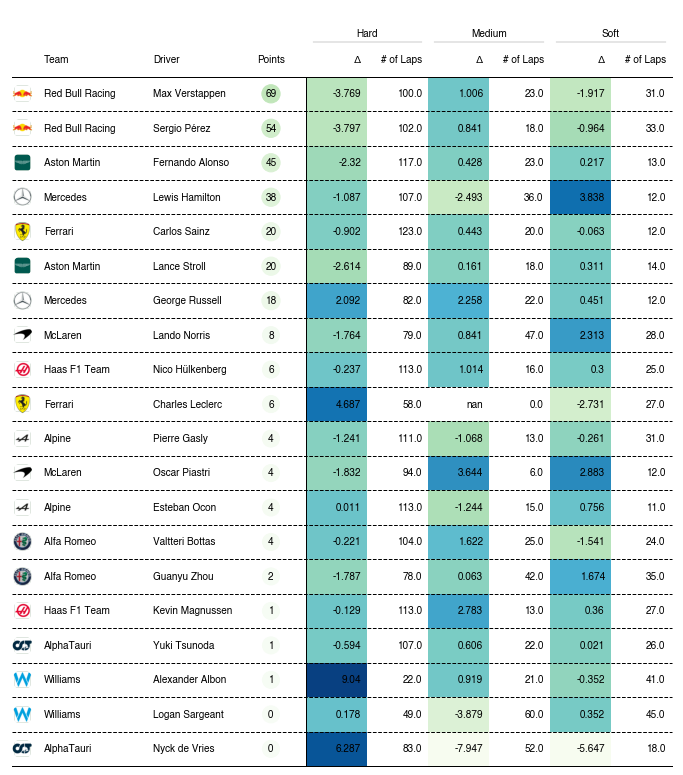

In [65]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from plottable.cmap import normed_cmap

fig, ax = plt.subplots(figsize=(12, 14))

compounds = ['Hard', 'Medium', 'Soft']

# Create plottable tables for the hard compound
hard_table = Table(
    df,
    row_dividers=True,
    footer_divider=True,
    column_definitions=[
        ColumnDefinition('Logo', title='', plot_fn=circled_image, width=0.1),
        ColumnDefinition('Team', title='Team', width=0.55,
                         textprops={"ha": "left", "weight": "bold"}),
        ColumnDefinition('Driver Name', title='Driver', width=0.45, textprops={"ha": "left"}),
        ColumnDefinition('points', title='Points', width=0.35, cmap=plt.cm.Greens, textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.35}
        }),
        ColumnDefinition('Hard', title='Δ', cmap=normed_cmap(df["Hard"], cmap=plt.cm.GnBu, num_stds=2.5),
                         width=0.3, group='Hard', border="left"),
        ColumnDefinition('HardLaps', title='# of Laps',
                         width=0.3, group='Hard'),
        ColumnDefinition('Medium', title='Δ', cmap=normed_cmap(df["Medium"], cmap=plt.cm.GnBu, num_stds=2.5),
                         width=0.3, group='Medium'),
        ColumnDefinition('MediumLaps', title='# of Laps',
                         width=0.3, group='Medium'),
        ColumnDefinition('Soft', title='Δ', cmap=normed_cmap(df["Soft"], cmap=plt.cm.GnBu, num_stds=2.5),
                         width=0.3, group='Soft'),
        ColumnDefinition('SoftLaps', title='# of Laps',
                         width=0.3, group='Soft')
    ],
    row_divider_kw={"linewidth": 1, "linestyle": "dashed"},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "solid"},
)


In [67]:
# download a high resolution image of the table
fig.savefig('hard_table.png', dpi=300)